In [1]:
import os
os.chdir('C:/Users/emrijai/Documents/IPython Notebooks/MS7331/Project1/MSDS7331_Project1')
os.getcwd()

'C:\\Users\\emrijai\\Documents\\IPython Notebooks\\MS7331\\Project1\\MSDS7331_Project1'

In [2]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData.csv')

#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee','last_pymnt_d',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'installment', 'mths_since_last_major_derog', 'desc',
           'issue_d', 'addr_state', 'tot_coll_amt', 'tot_cur_bal', 'member_id', 'total_rec_prncp', 'total_rec_int',
           'total_rec_late_fee', 'loan_amnt', 'out_prncp', 'total']:
    if col in loan_df:
        del loan_df[col]

#Create new variables for classification
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Numerical classification of grade
tmp_df = pd.get_dummies(loan_df.grade,prefix='Grade')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "grade" in loan_df:
    del loan_df["grade"]
    
#Numerical classification of employment length
tmp_df = pd.get_dummies(loan_df.emp_length,prefix='Employ')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "emp_length" in loan_df:
    del loan_df["emp_length"]

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0, 1, 2, 3, 4, 5])

if "int_rate" in loan_df:
    del loan_df["int_rate"]

#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = 0

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = 1

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = 1

#Secondary classification of loan class for further analysis of data
# comparing the historical data (good/bad loans) to current data (loans still in progress)
# Loans are classified as 'Bad' if loans are bad
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class2'] = 'Bad'
# Loans are classified as 'Good' if loans are good
loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class2'] = 'Good'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class2'] = 'Good'
# Loans are classified as 'Current' if loans are current/still in progress
loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class2'] = 'Current'

if "loan_status" in loan_df:
    del loan_df["loan_status"]

#Nominal classification of verification status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'Verify_Status'] = 0

if "verification_status" in loan_df:
    del loan_df["verification_status"]

#Nominal classification of home ownership
tmp_df = pd.get_dummies(loan_df.home_ownership,prefix='Home')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "home_ownership" in loan_df:
    del loan_df["home_ownership"]

#Impute missing data values with median
for col in ['total_acc']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value= 0 )
    loan_df[col] = df_temp    

    
tmp_df = pd.get_dummies(loan_df.purpose,prefix='Loan_Purpose')
loan_df = pd.concat((loan_df,tmp_df),axis=1)

if 'purpose' in loan_df:
    del loan_df['purpose']    
    
# Create separate data frames for future analysis and breakdown
loan_df_unfinished = loan_df[loan_df['Loan_Class2'] == 'Current'] #Data of uncompleted loans
loan_df_finished = loan_df[(loan_df['Loan_Class2'] == 'Bad') | (loan_df['Loan_Class2']=='Good')] #Data of completed loans


loan_df.copy()

if "Loan_Class2" in loan_df:
    del loan_df["Loan_Class2"]

print loan_df_finished.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270887 entries, 0 to 887371
Data columns (total 53 columns):
funded_amnt                        270887 non-null float64
term                               270887 non-null int64
annual_inc                         270887 non-null float64
dti                                270887 non-null float64
delinq_2yrs                        270887 non-null float64
inq_last_6mths                     270887 non-null float64
open_acc                           270887 non-null float64
total_acc                          270887 non-null float64
total_pymnt                        270887 non-null float64
acc_now_delinq                     270887 non-null float64
Grade_A                            270887 non-null float64
Grade_B                            270887 non-null float64
Grade_C                            270887 non-null float64
Grade_D                            270887 non-null float64
Grade_E                            270887 non-null float64
Grade_

In [3]:
loan_df_finished.head()

,funded_amnt,term,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,total_acc,total_pymnt,acc_now_delinq,...,Loan_Purpose_home_improvement,Loan_Purpose_house,Loan_Purpose_major_purchase,Loan_Purpose_medical,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_renewable_energy,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding
0,5000.0,36,24000.0,27.65,0.0,1.0,3.0,9.0,5861.071414,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2500.0,60,30000.0,1.00,0.0,5.0,3.0,4.0,1008.710000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2400.0,36,12252.0,8.72,0.0,2.0,2.0,10.0,3003.653644,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10000.0,36,49200.0,20.00,0.0,1.0,10.0,37.0,12226.302212,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,5000.0,36,36000.0,11.20,0.0,3.0,9.0,12.0,5631.377753,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
loan_df_unfinished.head()

,funded_amnt,term,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,total_acc,total_pymnt,acc_now_delinq,...,Loan_Purpose_home_improvement,Loan_Purpose_house,Loan_Purpose_major_purchase,Loan_Purpose_medical,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_renewable_energy,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding
4,3000.0,60,80000.0,17.94,0.0,0.0,15.0,38.0,3242.17,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,7000.0,60,47004.0,23.51,0.0,1.0,7.0,11.0,8136.84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,10000.0,60,29120.0,22.83,0.0,1.0,11.0,31.0,11622.36,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,12500.0,60,27000.0,16.04,0.0,3.0,6.0,24.0,13506.54,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,8950.0,60,40000.0,19.47,0.0,1.0,5.0,6.0,10713.52,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
from sklearn.cross_validation import ShuffleSplit

if 'Loan_Class' in loan_df:
    y = loan_df['Loan_Class'].values
    del loan_df['Loan_Class']
    X = loan_df.values
    
num_cv_iterations = 5
num_instances = len(y)
cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

print cv_obj

ShuffleSplit(887379, n_iter=5, test_size=0.2, random_state=None)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(cv_obj):
    logreg_obj.fit(X[train_indices],y[train_indices])  # train object
    y_hat = logreg_obj.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(y[test_indices],y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat)

====Iteration 0  ====
accuracy 0.930210281954
confusion matrix
[[     0  12386]
 [     0 165090]]
====Iteration 1  ====
accuracy 0.930649777998
confusion matrix
[[     0  12308]
 [     0 165168]]
====Iteration 2  ====
accuracy 0.930717392774
confusion matrix
[[     0  12296]
 [     0 165180]]
====Iteration 3  ====
accuracy 0.931489328135
confusion matrix
[[     0  12159]
 [     0 165317]]
====Iteration 4  ====
accuracy 0.931382271406
confusion matrix
[[     0  12178]
 [     0 165298]]


In [7]:
loan_df_finished['isGoodLoan'] = loan_df_finished['Loan_Class2'] == 'Good'
loan_df_finished.isGoodLoan = loan_df_finished.isGoodLoan.astype(np.int)

#Remove Loan_Class and Loan_Class2 from the data frame
if "Loan_Class" in loan_df_finished:
    del loan_df_finished["Loan_Class"]
if "Loan_Class2" in loan_df_finished:
    del loan_df_finished["Loan_Class2"]
    
loan_df_finished.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270887 entries, 0 to 887371
Data columns (total 52 columns):
funded_amnt                        270887 non-null float64
term                               270887 non-null int64
annual_inc                         270887 non-null float64
dti                                270887 non-null float64
delinq_2yrs                        270887 non-null float64
inq_last_6mths                     270887 non-null float64
open_acc                           270887 non-null float64
total_acc                          270887 non-null float64
total_pymnt                        270887 non-null float64
acc_now_delinq                     270887 non-null float64
Grade_A                            270887 non-null float64
Grade_B                            270887 non-null float64
Grade_C                            270887 non-null float64
Grade_D                            270887 non-null float64
Grade_E                            270887 non-null float64
Grade_

In [8]:
if 'isGoodLoan' in loan_df_finished:
    updated_y = loan_df_finished['isGoodLoan'].values
    del loan_df_finished['isGoodLoan']
    updated_X = loan_df_finished.values
    
num_cv_iterations = 5
num_instances = len(updated_y)
updated_cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

print updated_cv_obj

ShuffleSplit(270887, n_iter=5, test_size=0.2, random_state=None)


In [9]:
updated_logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

====Iteration 0  ====
accuracy 0.978478349145
confusion matrix
[[11182  1075]
 [   91 41830]]
====Iteration 1  ====
accuracy 0.978662925911
confusion matrix
[[11178  1068]
 [   88 41844]]
====Iteration 2  ====
accuracy 0.980600981948
confusion matrix
[[11191   964]
 [   87 41936]]
====Iteration 3  ====
accuracy 0.978312230056
confusion matrix
[[11154  1088]
 [   87 41849]]
====Iteration 4  ====
accuracy 0.980527151242
confusion matrix
[[11120   982]
 [   73 42003]]


In [10]:
from sklearn.preprocessing import StandardScaler

# iterate over the coefficients
weights = updated_logreg_obj.coef_.T # take transpose to make a column vector
variable_names = loan_df_finished.columns
for coef, name in zip(weights,variable_names):
    print name, 'has weight of', coef[0]

funded_amnt has weight of -0.00176065322926
term has weight of 0.0082766931763
annual_inc has weight of 1.98165159611e-05
dti has weight of 0.00394714233025
delinq_2yrs has weight of 2.66435509014e-05
inq_last_6mths has weight of 3.57520198891e-05
open_acc has weight of 0.00211733611438
total_acc has weight of 0.00530975647225
total_pymnt has weight of 0.00177279104371
acc_now_delinq has weight of 8.9826644947e-07
Grade_A has weight of 0.000160111618359
Grade_B has weight of 0.000115681572523
Grade_C has weight of 5.07568961084e-05
Grade_D has weight of -2.99015363542e-05
Grade_E has weight of -2.34217599937e-05
Grade_F has weight of -1.43657859728e-05
Grade_G has weight of -4.68841224037e-06
Employ_1 year has weight of 2.62235733864e-05
Employ_10+ years has weight of 4.47031755239e-05
Employ_2 years has weight of 3.14480176915e-05
Employ_3 years has weight of 2.51976037621e-05
Employ_4 years has weight of 1.66280418508e-05
Employ_5 years has weight of 1.01759057877e-05
Employ_6 years 

In [11]:
warnings.simplefilter("ignore")

#normalize the features
scale_obj = StandardScaler()
scale_obj.fit(updated_X[train_indices])

X_train_scaled = scale_obj.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scale_obj.transform(updated_X[test_indices])

updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
print 'accuracy:', acc 
print conf
print 

# sort these attributes and spit them out
zip_vars = zip(updated_logreg_obj.coef_.T,loan_df_finished.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print name, 'has weight of', coef[0] # now print them out

accuracy: 0.97930894459
[[11054  1048]
 [   73 42003]]

delinq_2yrs has weight of -0.00130858182106
Employ_4 years has weight of -0.00184302757981
Loan_Purpose_moving has weight of 0.00363484801379
Loan_Purpose_renewable_energy has weight of -0.00676042439717
Employ_9 years has weight of -0.00741112838177
Loan_Purpose_home_improvement has weight of -0.00774791316273
Loan_Purpose_vacation has weight of -0.00960080570612
Loan_Purpose_major_purchase has weight of 0.0101233209749
Employ_< 1 year has weight of 0.0103440283031
Employ_6 years has weight of -0.0109351746402
Loan_Purpose_car has weight of -0.0114249545819
Loan_Purpose_medical has weight of -0.0119850768812
Loan_Purpose_house has weight of 0.012782240591
Employ_7 years has weight of -0.013537804708
Employ_3 years has weight of 0.0145597942814
Home_NONE has weight of -0.0146588986381
Employ_2 years has weight of 0.0154385833904
Employ_10+ years has weight of 0.0158503719347
Home_ANY has weight of 0.016741692883
Employ_1 year has 

In [12]:
warnings.simplefilter("ignore")

# SVM using 'hash' for loss
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'SVM:', acc

SVM: 0.869596515191


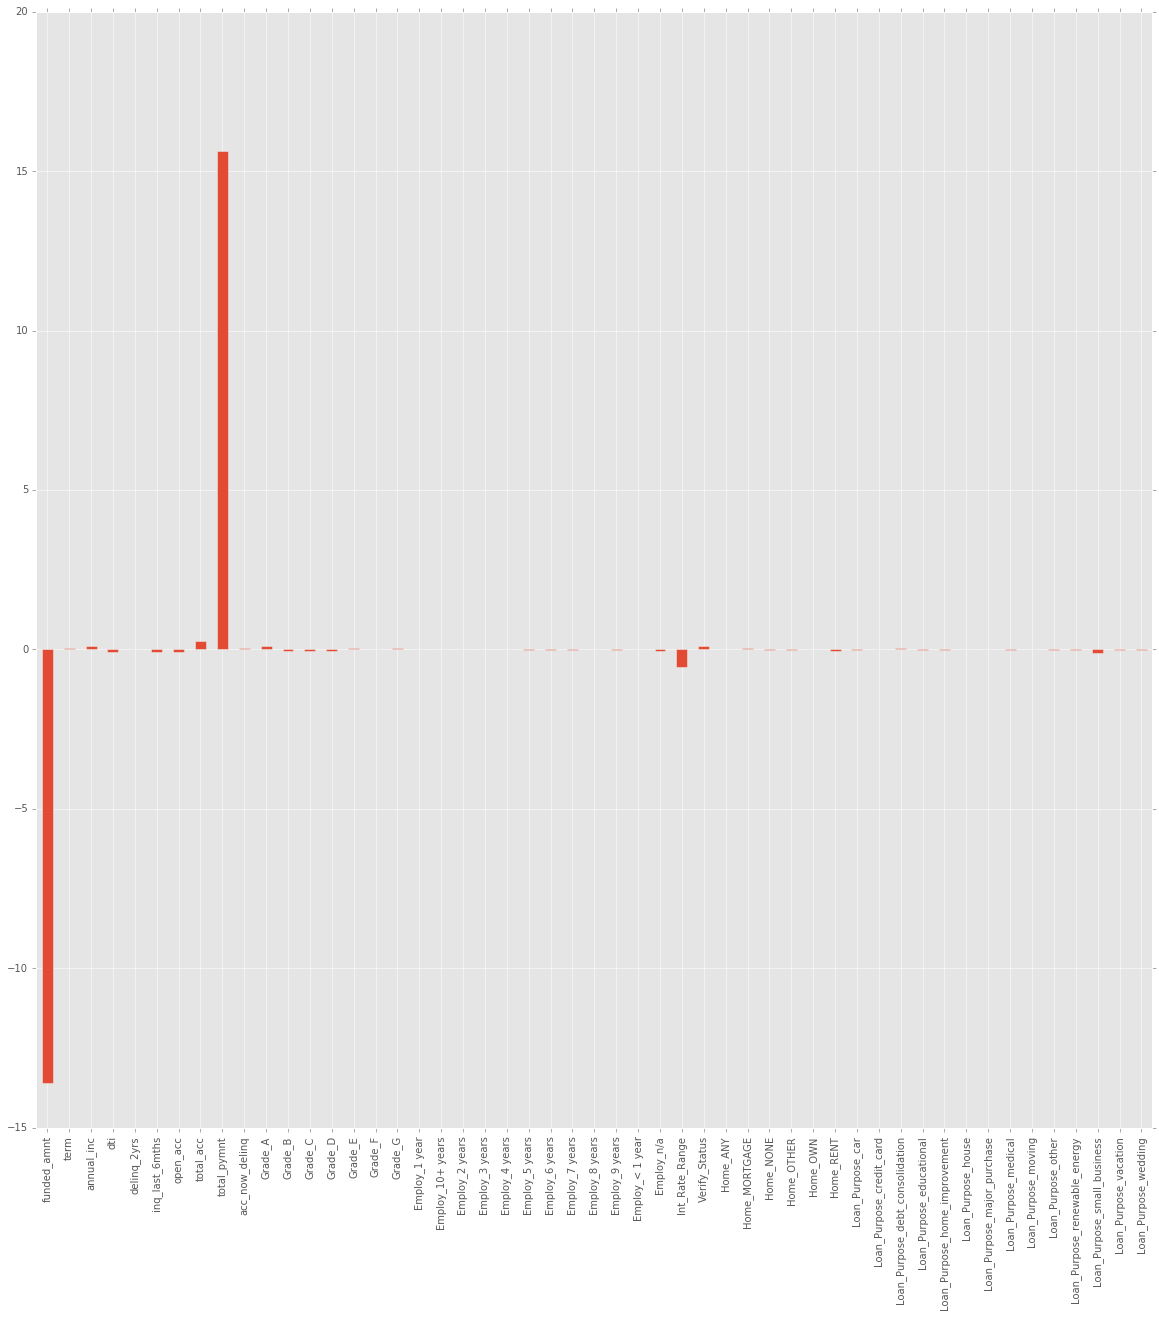

In [13]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))

weights = pd.Series(updated_logreg_obj.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar')
plt.show()

In [14]:
warnings.simplefilter("ignore")

# SVM using 'log' for loss instead of 'hinge'
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'SVM:', acc

SVM: 0.837590904057
